<a href="https://colab.research.google.com/github/van-dang/DMRI-FEM-Cloud/blob/master/MultilayeredDiskVariablePermeability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [1]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
try:
    from google.colab import files
except:
    print("This is not google.colab")
    
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [3]:
import sympy as sp  
exists = os.path.isfile('DmriFemLib.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemLib.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/DMRI-FEM-Cloud/master/DmriFemLib.py
from DmriFemLib import *
      

Load pre-defined functions from GitHub


# Working on the mesh and submesh

Extracting cell markers from: multi_layered_disk.msh ...
Extracted successfully on: 908 elements
Partition marker list: ['0', '1', '2']
Wrote to: pmk_multi_layered_disk.xml


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique 

partition list: [0, 1, 2]
Partition markers: [0, 1, 2]


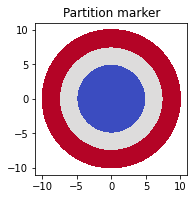

In [4]:
geo_choice = 2
################################################################################
############## Create multilayered domains using gmsh ##########################
if geo_choice == 2:
    mesh_name = "multi_layered_disk"

    is_geo_file_exist = os.path.isfile(mesh_name+'.geo')  
    if is_geo_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/DMRI-FEM-Cloud/mesh/$mesh_name''.geo

    # Modify .geo file from 4 layers to 3 layers      
    !sed -i 's/5, 7.5, 10, 13/5, 7.5, 10/g' $mesh_name''.geo
      
    # Create mesh from geo file by gmsh
    !gmsh -3 $mesh_name''.geo -o $mesh_name''.msh
    
    # Convert .msh to .xml using dolfin-convert
    !dolfin-convert $mesh_name''.msh $mesh_name''.xml
    clear_output()

    mymesh = Mesh(mesh_name+".xml");  

    GetPartitionMarkers(mesh_name+".msh", "pmk_"+mesh_name+".xml")

    partition_marker = MeshFunction("size_t", mymesh, mymesh.topology().dim())

    File("pmk_"+mesh_name+".xml")>>partition_marker

    phase, partion_list = CreatePhaseFunc(mymesh, [], [], partition_marker)    

    D_array = [3e-3, 1e-3, 3e-3];
    D_dictionary = dict(zip(partion_list, D_array))
    print("partition list:",partion_list)
    
################################################################################
############## Save, Plot phase functions and submeshes to verify ##############
File("Phase.pvd")<<phase
print("Partition markers:", partion_list)
if mymesh.topology().dim()==2:
    plt.subplot(1, 2, 2); plot(partition_marker, cmap="coolwarm",  title="Partition marker");

# Solve the Bloch-Torrey equation

Domain size: xmin=-10.000000, ymin=-10.000000, zmin=0.000000, xmax=10.000000, ymax=10.000000, zmax=0.000000
Function Space for Two-compartment Domains has 4 components
(ur0, ui0, ur1, ur1): r-real, i-imaginary
Initialize a standard function space.
Impose Diffusion Tensor ...
t:   0.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 0.00%
t: 500.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 1.25%
t: 1000.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 2.49%
t: 1500.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 3.74%
t: 2000.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 4.99%
t: 2500.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 6.23%
t: 3000.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 7.48%
t: 3500.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 8.73%
t: 4000.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 9.98%
t: 4500.00  T: 40000.00 dt: 100.0 qvalue: 1.369306e-05 Completed 11.22%
t: 5000.00  T: 

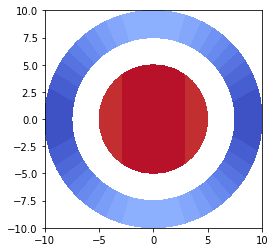

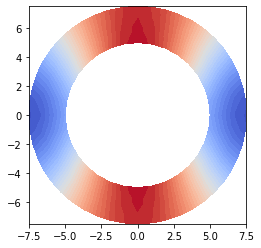

In [11]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

bvalues = [1000]

for bvalue in bvalues:
    #################################################################################
    #########################  Pre-defined parameters ###############################
    mri_para.bvalue = bvalue                             # bvalue
    mri_para.delta, mri_para.Delta = 20000, 20000# 10600, 43100        # time sequence
    mri_para.set_gradient_dir(mymesh, 1, 0, 0)           # gradient direction
    mri_para.T = mri_para.Delta+mri_para.delta
    mri_para.fs_sym = sp.Piecewise(
                    (  1., mri_para.s < mri_para.delta ),
                    (  0., mri_para.s < mri_para.Delta ),
                    ( -1., mri_para.s < mri_para.T ),
                    (  0., True )  
                ) 

    mri_para.Apply()
    mri_simu.k = 100;                                    # time-step size
    mri_simu.nskip = 5;                                  # frequency to print ouputs

    mydomain = MyDomain(mymesh, mri_para)
    mydomain.phase = phase
    mydomain.PeriodicDir = [0, 0, 0];            # Direction of the periodicity
    mydomain.IsDomainPeriodic = False            # Confirm if the mesh if periodic
    mydomain.IsDomainMultiple = True             # Confirm if the mesh is multiple

    ###################### Set up permeability #####################################
    kappa_tensor = [[0,0,0],[0,0,0],[0,0,0]] 
    kappa_tensor[0][1] = kappa_tensor[1][0] = 1e-4
    kappa_tensor[1][2] = kappa_tensor[2][1] = 1e-5

    CR = FunctionSpace(mymesh, "CR",1)
    CR_dofmap = CR.dofmap() 
    kappa = Function(CR)
    topo_dim = mymesh.topology().dim()
    mymesh.init(topo_dim-1,topo_dim) # Build connectivity between facets and cells
    facet_f = MeshFunction("double", mymesh, topo_dim - 1)
    for facet in facets(mymesh): 
      adjacent_cells = facet.entities(topo_dim) 
      if len(adjacent_cells)>1:
        domain_marker1 = partition_marker[adjacent_cells[0]]                                                  
        domain_marker2 = partition_marker[adjacent_cells[1]] 
        if domain_marker1!=domain_marker2:
          facet_f[facet] = kappa_tensor[domain_marker1][domain_marker2]
    for cell in cells(mymesh):                                                         
      dofs = CR_dofmap.cell_dofs(cell.index())                                          
      for i, facet in enumerate(facets(cell)):                                       
        kappa.vector()[dofs[i]] = facet_f[facet]    
    mydomain.kappa = kappa                     # Permeability
    ################################################################################

    mydomain.Apply()   # Call Apply before setting the diffusion tensor
    ################################################################################
    # Impose the diffusion coefficient
    dofmap_DG = mydomain.V_DG.dofmap()
    d00 = Function(mydomain.V_DG); d01 = Function(mydomain.V_DG); d02 = Function(mydomain.V_DG)
    d10 = Function(mydomain.V_DG); d11 = Function(mydomain.V_DG); d12 = Function(mydomain.V_DG)
    d20 = Function(mydomain.V_DG); d21 = Function(mydomain.V_DG); d22 = Function(mydomain.V_DG)

    for cell in cells(mymesh):
        p = cell.midpoint() # the coordinate of the cell center.
        cmk = partition_marker[cell.index()]
        cell_dof = dofmap_DG.cell_dofs(cell.index())
        d00.vector()[cell_dof] = D_dictionary[cmk]; 
        d11.vector()[cell_dof] = D_dictionary[cmk]; 
        d22.vector()[cell_dof] = D_dictionary[cmk];

    mydomain.ImposeDiffusionTensor(d00, d01, d02, d10, d11, d12, d20, d21, d22)
    #################################################################################
    #################################################################################

    # linsolver = PETScLUSolver("mumps")
    linsolver = KrylovSolver("bicgstab")
    linsolver.parameters["absolute_tolerance"] = 1e-9
    linsolver.parameters["relative_tolerance"] = 1e-8
    linsolver.parameters["maximum_iterations"] = 10000

    mri_simu.solve(mydomain, mri_para, linsolver)

    ctext = ''; # text to comment in the log file.
    PostProcessing(mydomain, mri_para, mri_simu, plt, ctext)


# Reference solutions

In [6]:
# The results were generated by the Matrix Formalism method propsed in
# D.S. Grebenkov, Pulsed-gradient spin-echo monitoring of restricted 
# diffusion in multilayered structures, J. Magn. Reson., 205 (2) (2010)

# # # # # # # # # # # # # # # # D.I.S.K # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # mydomain.PeriodicDir = [0, 0, 0]; # # # # # # # # # # # # # # 
# D=[3 1 3]*1e-3 mm^2/s, kappa01=kappa10=1e-4m/s, kappa12=kappa21=5e-5m/s
# # # # # # # # # R=[5,7.5,10], PGSE delta=Delta=40000 # # # # # # # # # # # # #
# bvalue    # Signal
# 0.000e+00 # 1.000e+00'
# 1.000e+03 # 7.163e-01'
# 2.000e+03 # 5.245e-01'
# 3.000e+03 # 3.954e-01'
# 4.000e+03 # 3.080e-01'
# 5.000e+03 # 2.482e-01'
# 6.000e+03 # 2.061e-01'
# 7.000e+03 # 1.754e-01'
# 8.000e+03 # 1.517e-01'
# 9.000e+03 # 1.326e-01'
# 1.000e+04 # 1.165e-01'
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # R=[5,7.5,10], PGSE delta=Delta=20000 # # # # # # # # # # # # #
# bvalue    # Signal
# 0.000e+00 # 1.000e+00'
# 1.000e+03 # 5.886e-01'
# 2.000e+03 # 3.845e-01'
# 3.000e+03 # 2.770e-01'
# 4.000e+03 # 2.134e-01'
# 5.000e+03 # 1.703e-01'
# 6.000e+03 # 1.383e-01'
# 7.000e+03 # 1.136e-01'
# 8.000e+03 # 9.468e-02'
# 9.000e+03 # 8.067e-02'
# 1.000e+04 # 7.060e-02'